In [63]:
import statsmodels
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
# from statsmodels.tsa.vector_ar.varmax_model import VARMAX as VAR
import time
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

In [42]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from cycler import cycler

hereon_color_array = np.array([
    [230, 0, 70],
    [0, 145, 160],
    [0, 170, 230],
    [250, 180, 35],
    [0, 70, 125],
    [175, 25, 60],
    [170, 200, 70],
    [250, 115, 80],
    [140, 90, 180],

])
hereon_color_array = hereon_color_array / 255
hereon_cmap = ListedColormap(hereon_color_array)
mpl.rc('image', cmap='gray')
mpl.rcParams['axes.prop_cycle'] = cycler(color=hereon_color_array)
sns.set_palette(hereon_color_array)

In [43]:
data = np.array([np.sin(np.linspace(0, np.pi*2*1007, 24168)) + np.random.uniform(0,1, size=24168) for _ in range(14)])
names = ["a", "b", "c", "as", "asd", "dfg", "jht", "hg", "hjn", "m", "hgw", "re", "ju", "ukj"]
dates = pd.date_range(start="2022-01-01", freq="h", periods=len(data.T))
with open("example_data_file.csv", "w") as f:
    f.write("Load [MWh],Time [s],City\n")
    for event, name in zip(data, names):
        for element, datum in zip(event, dates):
            f.write(f"{element:.5f},{datum.__str__()},{name}\n")

In [44]:
train_data_file = "example_data_file.csv"
valid_data_file = "example_data_file.csv"
prediction_time_window=168
past_time_window=168

In [45]:
df = pd.read_csv(train_data_file)
df

,Load [MWh],Time [s],City
0,0.81044,2022-01-01 00:00:00,a
1,0.94560,2022-01-01 01:00:00,a
2,1.47590,2022-01-01 02:00:00,a
3,1.67202,2022-01-01 03:00:00,a
4,1.46456,2022-01-01 04:00:00,a
...,...,...,...
338347,-0.19071,2024-10-03 19:00:00,ukj
338348,-0.11633,2024-10-03 20:00:00,ukj
338349,-0.05987,2024-10-03 21:00:00,ukj
338350,0.00914,2024-10-03 22:00:00,ukj


In [46]:
city_data = []
city_names = pd.unique(df["City"])
for city in tqdm(city_names):
    city_data.append(df[df["City"] == city]["Load [MWh]"].to_numpy())

unique_time = np.expand_dims(pd.to_datetime(df[df["City"] == city]["Time [s]"]).view(np.int64).to_numpy() / 10**9 / 3600, 1)
city_data = np.moveaxis(np.array(city_data), 0, -1)
train_dataset = city_data

var_data = np.concatenate([unique_time, train_dataset], axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 62.91it/s]


In [67]:
# fit the model:
model = VARMAX(var_data)
model_fit = model.fit(maxiter=1)

C:\Users\Tobias\Anaconda3\envs\hydra\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [52]:
import torch
from torch.utils.data import Dataset, DataLoader


class CustomLoadDataset(Dataset):
    def __init__(self, data_file, historic_window, forecast_horizon, city_names, device=None, normalize=True):
        # Input sequence length and output (forecast) sequence length
        self.historic_window = historic_window
        self.forecast_horizon = forecast_horizon
        
        df = pd.read_csv(data_file)
        # Load Data from csv to Pandas Dataframe
        city_data = []
        for city in tqdm(city_names):
            city_data.append(df[df["City"] == city]["Load [MWh]"].to_numpy())

        unique_time = np.expand_dims(pd.to_datetime(df[df["City"] == city]["Time [s]"]).view(np.int64).to_numpy() / 10**9 / 3600, 1)
        city_data = np.moveaxis(np.array(city_data), 0, -1)
        self.dataset = city_data
        self.dataset = np.concatenate([unique_time, self.dataset], axis=1)

    def __len__(self):
#         return int(self.dataset.shape[0] - self.historic_window - self.forecast_horizon)
        return 100

    def __getitem__(self, idx):
        # translate idx (day nr) to array index
        x = self.dataset[idx:idx+self.historic_window, ]
        y = self.dataset[idx+self.historic_window: idx+self.historic_window + self.forecast_horizon, ]

        return x, y

In [53]:
valid_dataset = CustomLoadDataset(data_file=valid_data_file, 
                                  historic_window=past_time_window, 
                                  forecast_horizon=prediction_time_window,
                                  city_names=city_names,
                                  device=None, 
                                  normalize=False)

valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=True,
           num_workers=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 58.09it/s]


In [56]:
errors = []
counter = 0

for x,y in tqdm(valid_dataloader):
    x = x.squeeze(0).cpu().numpy()
    y = y.squeeze(0).cpu().numpy()[:, 1:]
    preds = model_fit.predict(steps=168)[:, 1:]
    
    # preds = valid_dataset.revert_normalization(preds)
    # y = valid_dataset.revert_normalization(y)
    
    all_predictions = preds
    all_val = y
    errors.append(mean_absolute_error(y_true=y, y_pred=preds))
    counter += 1
    if counter > 100:
        break

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 751.89it/s]


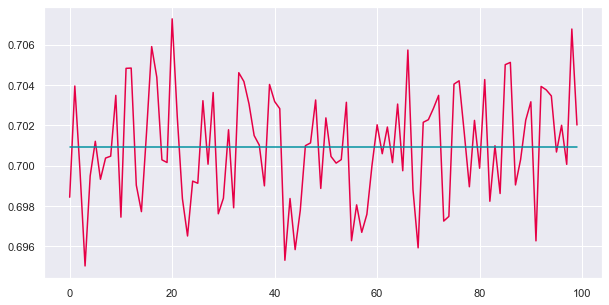

In [57]:
errors = np.array(errors)
mean_error = np.mean(errors)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(errors)
ax.plot(np.arange(len(errors)), [mean_error for _ in range(len(errors))])

In [58]:
mean_error

0.700938585712252

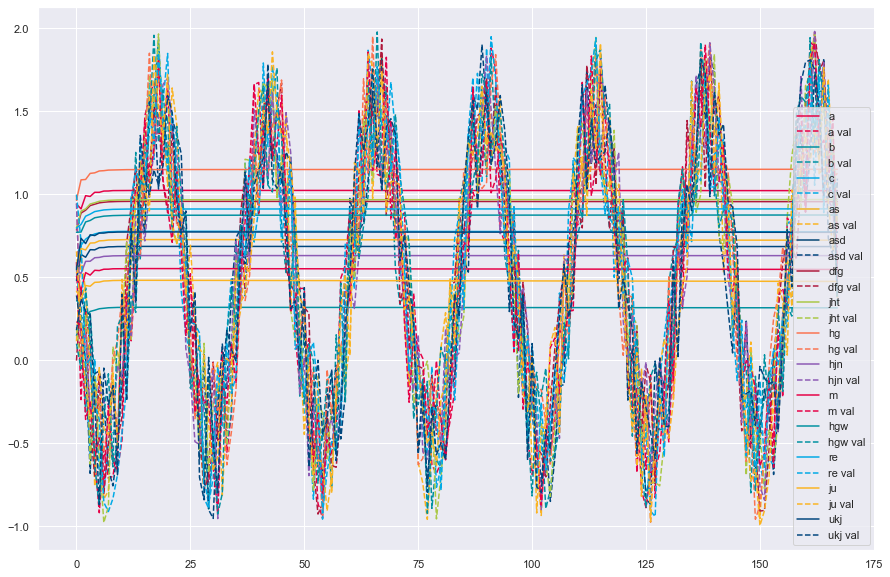

In [59]:
fig, ax1 = plt.subplots(figsize=(15,10), nrows=1)
for i, (this_pred, this_val) in enumerate(zip(np.array(all_predictions).T, np.array(all_val).T)):
    ax1.plot(np.arange(len(this_pred)), this_pred, label=city_names[i], color=hereon_color_array[i%9])
    ax1.plot(np.arange(len(this_pred)), this_val, label=city_names[i] + " val", color=hereon_color_array[i%9], ls="--")
ax1.legend()

## Parallel:

In [20]:
from joblib import Parallel, delayed

def do(x, y, counter):
    x = x.squeeze(0).cpu().numpy()
    y = y.squeeze(0).cpu().numpy()[:, 1:]
    preds = model_fit.forecast(x, steps=168)[:, 1:]

    return counter, preds

tqdm._instances.clear()
with Parallel(n_jobs=4, backend="threading") as parallel:
    results = parallel(delayed(do)(x, y, counter) for counter, (x, y) in enumerate(tqdm(valid_dataloader, position=0)))
sorted_predictions = np.array(list(pd.DataFrame(results, columns=["counter", "arrays"]).sort_values(by="counter")["arrays"].apply(lambda x: np.array(x))))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.42it/s]


In [33]:
def calc_error(x, y, counter):
    x = x.squeeze(0).cpu().numpy()
    y = y.squeeze(0).cpu().numpy()[:, 1:]
    preds = model_fit.forecast(x, steps=168)[:, 1:]
    error = mean_absolute_error(y_true=y, y_pred=preds)
    return counter, error

tqdm._instances.clear()
with Parallel(n_jobs=4) as parallel:
    results = parallel(delayed(do)(x, y, counter) for counter, (x, y) in enumerate(tqdm(valid_dataloader, position=0)))
sorted_predictions = np.array(list(pd.DataFrame(results, columns=["counter", "arrays"]).sort_values(by="counter")["arrays"].apply(lambda x: np.array(x))))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 70.13it/s]


In [34]:
sorted_predictions.mean()

0.5019173766824664

In [35]:
sorted_predictions = np.moveaxis(sorted_predictions, -1, 0)

final_predictions = []
for city in sorted_predictions:
    for prediction in city:
        final_predictions.append(prediction)


# remove normalization and convert to DataFrame
df = pd.DataFrame(final_predictions)

In [38]:
df

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
0,1.237508,1.424105,1.397879,1.510546,1.547930,1.340422,1.243493,1.010536,0.840545,0.489869,...,-0.491405,-0.575785,-0.420535,-0.346932,-0.185204,0.033425,0.256223,0.520797,0.813094,0.971232
1,-0.330034,-0.468977,-0.338683,-0.557629,-0.472418,-0.307948,-0.153817,0.028187,0.164352,0.613721,...,1.481197,1.506259,1.502686,1.361713,1.195789,1.032949,0.805167,0.456636,0.267112,0.014666
2,0.577801,0.372224,-0.023656,-0.341776,-0.456030,-0.330771,-0.545223,-0.464911,-0.307086,-0.148583,...,1.020659,1.241970,1.410485,1.480324,1.517320,1.496033,1.373699,1.217345,1.050948,0.801414
3,-0.036632,0.175221,0.373654,0.611380,0.969638,1.150476,1.547619,1.394422,1.709762,1.586443,...,0.487474,0.257112,-0.041434,-0.219346,-0.388103,-0.461008,-0.501779,-0.444764,-0.356715,-0.203538
4,0.387441,0.602652,0.979907,1.140771,1.547306,1.392743,1.697036,1.571085,1.397032,1.177032,...,-0.046081,-0.218434,-0.392134,-0.459219,-0.497823,-0.454674,-0.345852,-0.203569,-0.056147,0.170663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,1.569643,1.401659,1.486710,1.218066,0.956452,0.612855,0.511593,0.256732,0.009003,-0.110404,...,-0.391260,-0.273321,0.026369,0.303851,0.531451,0.763725,1.030730,1.189389,1.367118,1.438824
1396,1.578469,1.445268,1.424783,1.107886,1.018995,0.815420,0.493279,0.280185,0.152664,-0.147119,...,-0.422615,-0.230464,0.039150,0.214641,0.533992,0.736662,0.972375,1.215914,1.345681,1.457704
1397,1.366148,1.563164,1.517787,1.325388,1.184937,1.015636,0.793711,0.543057,0.122696,-0.026725,...,-0.450681,-0.408289,-0.263646,-0.088739,0.194409,0.443676,0.692086,0.985878,1.218892,1.358687
1398,-0.244891,-0.378764,0.016985,0.123091,0.449128,0.765446,1.146329,1.149918,1.342163,1.312392,...,1.033405,0.691057,0.515341,0.227224,-0.026101,-0.223151,-0.403327,-0.447562,-0.445073,-0.450115


In [95]:
df = pd.read_csv(train_data_file)
city_data = []
city_names = pd.unique(df["City"])
for city in tqdm(city_names):
    city_data.append(df[df["City"] == city]["Load [MWh]"].to_numpy())
unique_time = np.expand_dims(pd.to_datetime(df[df["City"] == city]["Time [s]"]), -1)
city_data = np.moveaxis(np.array(city_data), 0, -1)
train_dataset = city_data

# data = np.concatenate([unique_time, train_dataset], axis=1)
data = pd.DataFrame(train_dataset, columns=city_names)
data["time"] = unique_time
data = data.set_index("time")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 63.49it/s]


In [96]:
data

,a,b,c,as,asd,dfg,jht,hg,hjn,m,hgw,re,ju,ukj
time,,,,,,,,,,,,,,
2022-01-01 00:00:00,0.81044,0.69509,0.65763,0.49233,0.33564,0.58886,0.38035,0.24185,0.02758,0.62718,0.38143,0.35742,0.91099,0.81853
2022-01-01 01:00:00,0.94560,0.34107,1.04692,1.22173,0.47921,1.12451,0.33163,0.55589,0.50697,1.24994,0.26172,0.34187,1.24130,0.70435
2022-01-01 02:00:00,1.47590,0.52103,1.41248,0.66641,1.41380,0.89519,1.37734,1.06284,0.96860,0.80389,1.38604,1.28150,1.39538,1.38591
2022-01-01 03:00:00,1.67202,1.12229,1.27889,0.95723,0.93331,1.15146,0.94549,0.75771,1.13635,1.34733,1.48698,1.13521,1.17463,0.99861
2022-01-01 04:00:00,1.46456,1.66886,1.41873,1.39765,1.05045,1.05045,1.02586,1.32605,1.59295,0.88805,1.08512,1.01208,1.40988,1.52230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-03 19:00:00,-0.41764,-0.25241,-0.42436,-0.21518,-0.21864,-0.13231,-0.47095,-0.08334,-0.79441,-0.22039,-0.77365,-0.53438,-0.70022,-0.19071
2024-10-03 20:00:00,-0.21508,-0.66615,-0.06138,-0.69623,0.00872,0.09372,-0.13776,0.03497,-0.37357,-0.08810,-0.47632,-0.15524,-0.31612,-0.11633
2024-10-03 21:00:00,0.09825,0.39168,-0.02115,0.09999,0.35776,-0.37545,-0.22747,0.39642,-0.24156,0.01070,0.34801,-0.08029,0.42407,-0.05987


In [81]:
train_dataset.shape

(24168, 14)

In [92]:
data["time"] = 

,a,b,c,as,asd,dfg,jht,hg,hjn,m,hgw,re,ju,ukj
0,0.81044,0.69509,0.65763,0.49233,0.33564,0.58886,0.38035,0.24185,0.02758,0.62718,0.38143,0.35742,0.91099,0.81853
1,0.94560,0.34107,1.04692,1.22173,0.47921,1.12451,0.33163,0.55589,0.50697,1.24994,0.26172,0.34187,1.24130,0.70435
2,1.47590,0.52103,1.41248,0.66641,1.41380,0.89519,1.37734,1.06284,0.96860,0.80389,1.38604,1.28150,1.39538,1.38591
3,1.67202,1.12229,1.27889,0.95723,0.93331,1.15146,0.94549,0.75771,1.13635,1.34733,1.48698,1.13521,1.17463,0.99861
4,1.46456,1.66886,1.41873,1.39765,1.05045,1.05045,1.02586,1.32605,1.59295,0.88805,1.08512,1.01208,1.40988,1.52230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24163,-0.41764,-0.25241,-0.42436,-0.21518,-0.21864,-0.13231,-0.47095,-0.08334,-0.79441,-0.22039,-0.77365,-0.53438,-0.70022,-0.19071
24164,-0.21508,-0.66615,-0.06138,-0.69623,0.00872,0.09372,-0.13776,0.03497,-0.37357,-0.08810,-0.47632,-0.15524,-0.31612,-0.11633
24165,0.09825,0.39168,-0.02115,0.09999,0.35776,-0.37545,-0.22747,0.39642,-0.24156,0.01070,0.34801,-0.08029,0.42407,-0.05987
24166,0.71402,-0.25690,0.60277,0.08079,-0.06665,0.54018,0.33102,0.55497,0.50786,0.62460,0.73903,0.48463,0.19445,0.00914
